In [1]:
import os
os.chdir("../../../")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [ ]:
import scanpy as sc
import surgeon
sc.settings.set_figure_params(dpi=250, frameon=False)

In [4]:
sc.set_figure_params(dpi=200)

In [5]:
condition_key = "study"
cell_type_key = 'cell_type'
target_conditions = ["Pancreas SS2", "Pancreas CelSeq2"]

# Loading four pancrease datasets and data preparation

In [6]:
adata = sc.read("./data/pancreas/pancreas_normalized.h5ad")
adata

AnnData object with n_obs × n_vars = 15681 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

## Number of cells in each batch

In [7]:
adata.obs[condition_key].value_counts()

Pancreas inDrop         8391
Pancreas SS2            2961
Pancreas CelSeq2        2426
Pancreas CelSeq         1271
Pancreas Fluidigm C1     632
Name: study, dtype: int64

## Now we leave out one study  (Segerstolpe) for training the newtork

In [8]:
adata_for_training = adata[~adata.obs[condition_key].isin(target_conditions)]
adata_for_training

View of AnnData object with n_obs × n_vars = 10294 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [9]:
adata_out_of_sample = adata[adata.obs[condition_key].isin(target_conditions)]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 5387 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

## Train/Test Split

In [10]:
train_adata, valid_adata = surgeon.utils.train_test_split(
    adata_for_training, 0.80)

In [11]:
train_adata.shape, valid_adata.shape

((8235, 1000), (2059, 1000))

In [12]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())

# Create & Train model with training data

In [13]:
network = surgeon.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=10,
                             architecture=[128, 64, 32],
                             n_conditions=n_conditions,
                             lr=0.001,
                             alpha=0.00005,
                             beta=1000.0,
                             eta=1.0,
                             use_batchnorm=False,
                             clip_value=1000.0,
                             loss_fn='mse',
                             model_path="./models/CVAE/Pancreas/before/",
                             dropout_rate=0.05,
                             output_activation='relu')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 1000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 3)            0                                            
__________________________________________________________________________________________________
first_layer (FirstLayer)        (None, 128)          128384      data[0][0]                       
                                                                 encoder_labels[0][0]             
_____________________

## We assign each study to a numerical label 

In [14]:
conditions = adata_for_training.obs[condition_key].unique().tolist()
condition_encoder = surgeon.utils.create_dictionary(conditions, [])
condition_encoder

{'Pancreas inDrop': 0, 'Pancreas CelSeq': 1, 'Pancreas Fluidigm C1': 2}

## Training the network

In [15]:
network.train(train_adata,
              valid_adata,
              condition_key=condition_key,
              le=condition_encoder,
              n_epochs=1000,
              batch_size=1024,
              early_stop_limit=50,
              lr_reducer=40,
              save=True,
              retrain=True,
              n_per_epoch=0,
              verbose=50)

Instructions for updating:
Use tf.cast instead.


In [16]:
network.condition_encoder

{'Pancreas inDrop': 0, 'Pancreas CelSeq': 1, 'Pancreas Fluidigm C1': 2}

In [17]:
encoder_labels, _ = surgeon.utils.label_encoder(
    train_adata, label_encoder=network.condition_encoder, condition_key=condition_key)

In [18]:
latent_adata = network.to_mmd_layer(train_adata, encoder_labels, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 8235 × 32 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [19]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

/home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/mohsen/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/mohsen/lib/py

/home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


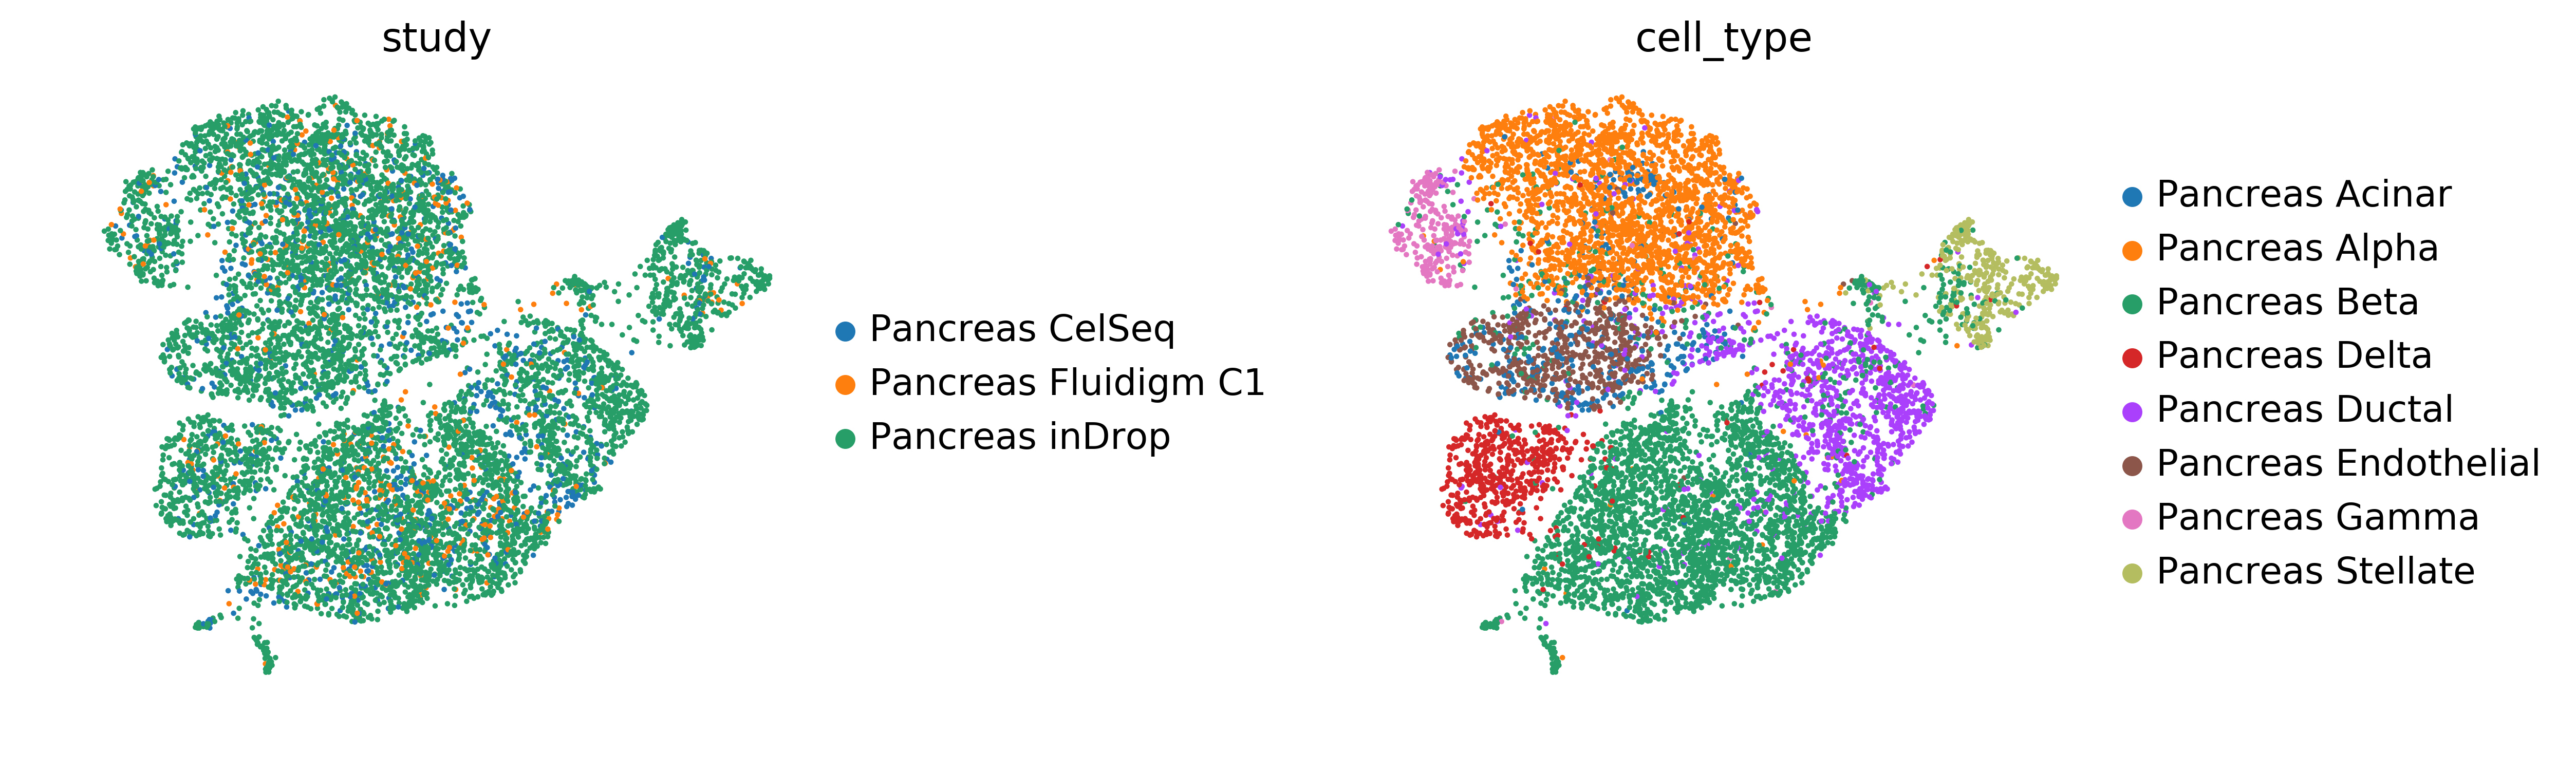

In [20]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], 
           frameon=False, wspace=0.6)

# Perfroming architecture Surgery

In [21]:
new_network = surgeon.operate(network, 
                              new_conditions=target_conditions,
                              init='Xavier', 
                              freeze=True,
                              freeze_expression_input=False,
                              remove_dropout=False)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 1000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 5)            0                                            
__________________________________________________________________________________________________
first_layer (FirstLayer)        (None, 128)          128640      data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, 128)          0           first_layer[0][0]                
__________

In [22]:
new_network.condition_encoder

{'Pancreas inDrop': 0,
 'Pancreas CelSeq': 1,
 'Pancreas Fluidigm C1': 2,
 'Pancreas SS2': 3,
 'Pancreas CelSeq2': 4}

## Train with small new dataset containing out-of-sample condition

In [23]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_out_of_sample, 0.80)

In [24]:
train_adata.shape, valid_adata.shape

((4309, 1000), (1078, 1000))

In [25]:
new_network.model_path = './models/CVAE/Pancreas/after/'

In [26]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  le=new_network.condition_encoder, 
                  n_epochs=1000,
                  batch_size=1024, 
                  early_stop_limit=50,
                  lr_reducer=40,
                  n_per_epoch=0,
                  save=True, 
                  retrain=True,
                  verbose=20)

## Projecting all data in to the latent space of the model 

In [27]:
encoder_labels, _ = surgeon.utils.label_encoder(adata_out_of_sample, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [28]:
adata_out_of_sample.obs[condition_key].value_counts()

Pancreas SS2        2961
Pancreas CelSeq2    2426
Name: study, dtype: int64

In [29]:
latent_adata = new_network.to_mmd_layer(adata_out_of_sample, encoder_labels, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 5387 × 32 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [30]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

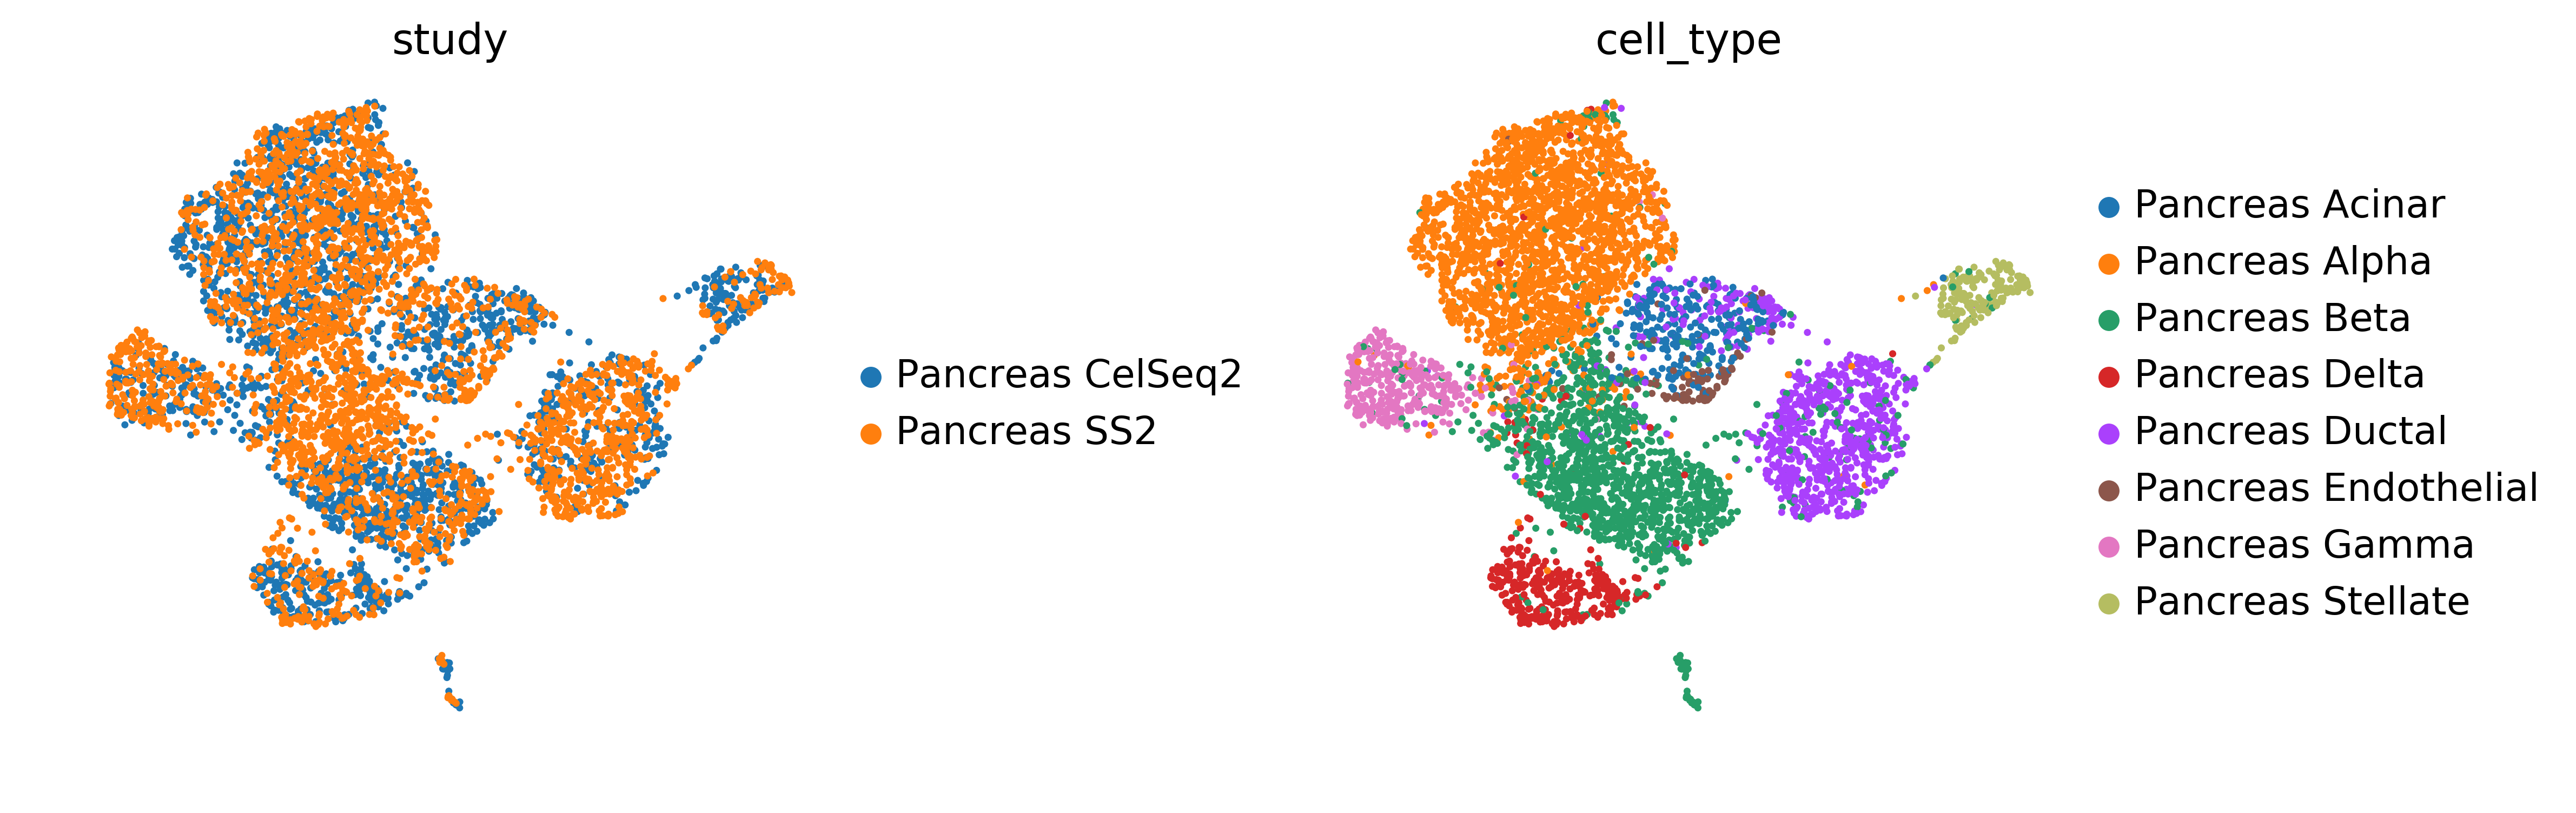

In [31]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], 
           wspace=0.5, frameon=False)